# Aberrated PSF -- sample generation
19/09/2018 : GOX (ULiege)

comparing PROPER and SOAPY

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#General-configuration" data-toc-modified-id="General-configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General configuration</a></span></li><li><span><a href="#SOAPY" data-toc-modified-id="SOAPY-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>SOAPY</a></span><ul class="toc-item"><li><span><a href="#Generate-PSFs" data-toc-modified-id="Generate-PSFs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate PSFs</a></span></li></ul></li><li><span><a href="#PROPER" data-toc-modified-id="PROPER-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PROPER</a></span><ul class="toc-item"><li><span><a href="#Wrapper-around-PROPER-to-generate-aberrated-PSF" data-toc-modified-id="Wrapper-around-PROPER-to-generate-aberrated-PSF-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Wrapper around PROPER to generate aberrated PSF</a></span></li><li><span><a href="#Generate-PSFs" data-toc-modified-id="Generate-PSFs-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate PSFs</a></span></li></ul></li><li><span><a href="#Results-:-comparison-SOAPY-vs-PROPER-PSFs" data-toc-modified-id="Results-:-comparison-SOAPY-vs-PROPER-PSFs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results : comparison SOAPY vs PROPER PSFs</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#recentering-with-VIP-experimentation" data-toc-modified-id="recentering-with-VIP-experimentation-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>recentering with VIP experimentation</a></span></li></ul></li></ul></li></ul></div>

In [759]:
import numpy
import numpy as np
%matplotlib nbagg
from matplotlib import pyplot
from matplotlib import pyplot as plt
#from tqdm import tqdm, tnrange
from astropy.io import fits
from scipy.io import loadmat, savemat
import time

In [760]:
import aotools
from aotools.turbulence import infinitephasescreen, phasescreen
from soapy import SCI, confParse

from gox_tools.plots.myNormalize import *

import proper

RAD2ARCSEC = 1. / (np.pi / 180 / 3600)

## General configuration

In [761]:
gridsize = 128
wavelength = 2.2e-6
# Nb of Zernike to use in the generation
nbOfZernike = 40
# Nb of PSFs to generate
nbOfPsfs = 100
# Telescope diameter
diameter = 1
pixelScale = 0.11 # [''/px]

# -- Generate set of random coefficients --
# uniformely distributed from [-1, 1]
coeffs = np.random.random((nbOfPsfs, nbOfZernike))*2 - 1

# Zernike mode index -- we will start from mode Z2=tip
coeffIdx = np.arange(2, nbOfZernike+2)  

# normalize to a given total wfs rms
normInNmRms = 2000
coeffs = np.array([coeffs[k, :] / np.abs(coeffs[k,:]).sum() * 
                   normInNmRms for k in range(nbOfPsfs)])



## SOAPY

<module 'soapy.confParse' from '/home/gilles/lib/python/soapy/soapy/confParse.py'>

In [762]:
SOAPY_CONF = "conf/psf.yaml"
config = confParse.loadSoapyConfig(SOAPY_CONF)

# Set the scientific camera field-of-view to 
# match the desired pixel scale
config.scis[0].pxlScale = pixelScale

config.calcParams()

# Assert configuration is similar for SOAPY and PROPER
assert config.sim.pupilSize == gridsize
assert config.scis[0].wavelength == wavelength
assert config.scis[0].pxls == gridsize

# Pupil mask
mask = aotools.circle(config.sim.pupilSize/2., config.sim.simSize)

# Create the PSF image
psfObj = SCI.PSF(config, nSci=0, mask=mask)

# Soapy camera pixel scale
pxscale_soapy = psfObj.fov / psfObj.nx_pixels
print("Pixel scale is {0:1f} ''/pixel".format(pxscale_soapy))
print("FoV is {0:1f} ''".format(config.scis[0].FOV))

confParse.py -> calcParams: Overriding sci FOV with pxlscale
Pixel scale is 0.110000 ''/pixel
FoV is 14.080000 ''


<IPython.core.display.Javascript object>


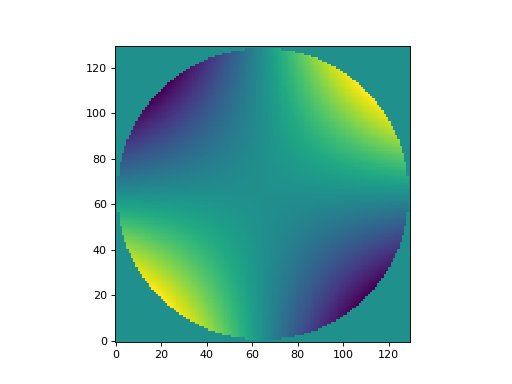

In [763]:
# Generate the Zernike modal basis
Zs = aotools.zernikeArray(nbOfZernike + 1, config.sim.pupilSize, norm='rms')
#Zs = np.array([np.pad(Zs[k,:,:], config.sim.simPad, 'constant', constant_values=0) for k in range(nbOfZernike+1)])

# Illustration of Zernike basis
# Astigmatism
plt.figure()
plt.imshow(Zs[4,:,:])


<IPython.core.display.Javascript object>


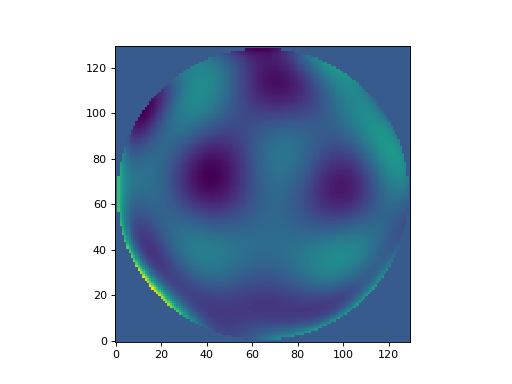

In [712]:
# Illustration of an input phase screen
tt = np.squeeze(np.sum(coeffs[-1, :, None, None] * Zs[1:, :,:], axis=0))
plt.figure()
plt.imshow(tt)

### Generate PSFs

In [764]:
psfs_soapy = np.zeros((nbOfPsfs, psfObj.detector.shape[0], psfObj.detector.shape[1]))

psfObj.frame(Zs[0,:,:])
t0 = time.time()

for i in range(nbOfPsfs):
    #print(i)
    aberrations = np.squeeze(np.sum(coeffs[i, :, None, None] * Zs[1:, :, :], axis=0))
    psfObj.frame(aberrations)
    #print('>>')
    psfs_soapy[i, :, :] = np.copy(psfObj.frame(aberrations))
t_soapy = time.time() - t0
print('Loop duration {0:2f}sec'.format(t_soapy))

Loop duration 0.588947sec


<IPython.core.display.Javascript object>


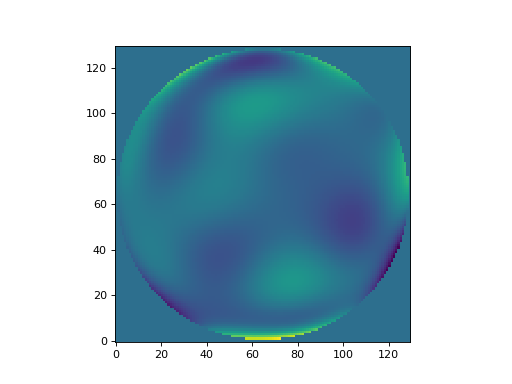

<IPython.core.display.Javascript object>


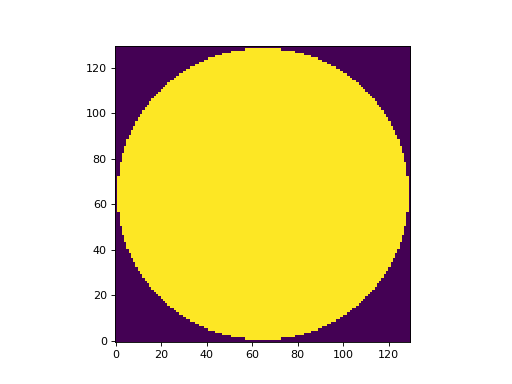

In [770]:
plt.figure()
plt.imshow(psfObj.los.phase)
plt.figure()
plt.imshow(psfObj.mask)

## PROPER

In [765]:
proper.print_it = False
proper.prop_use_fftw()
print(proper.use_fftw)
proper.prop_fftw_wisdom(gridsize)


True


'/home/gilles/.local/lib/python3.6/site-packages/PyPROPER3-1.0.1-py3.6-linux-x86_64.egg/proper/.128pix_wisdomfile'

### Wrapper around PROPER to generate aberrated PSF

In [766]:
def simple_prescription(wavelength, gridsize, diameter=1.0, fnumber=15, beamRatio=0.25,
                       zernikeIndex = None, rmsInNm=None):
    '''
    
    '''

    # Define entrance aperture diameter and other quantities
    diam = diameter
    focal_ratio = fnumber
    focal_length = diam * focal_ratio
    beam_ratio = beamRatio  # 0.5
    rmsInMeter = np.array(rmsInNm) * 1e-9
    
    # Define the wavefront
    wfo = proper.prop_begin(diam, wavelength, gridsize, beam_ratio)

    if zernikeIndex is not None:
        proper.prop_zernikes(wfo, zernikeIndex, rmsInMeter)

    # Define a circular aperture
    proper.prop_circular_aperture(wfo, diam / 2)

    # Define entrance
    proper.prop_define_entrance(wfo)

    # Define a lens
    proper.prop_lens(wfo, focal_length)

    # Propagate the wavefront
    proper.prop_propagate(wfo, focal_length)

    # End
    (wfo, sampling) = proper.prop_end(wfo)

    return (wfo, sampling)



Sampling is given by:
$$\lambda f_{\#} \times \mathrm{beam ratio}$$

Pixel scale [''/pixel] is 
$$\mathrm{sampling} / f \times 206264.8%$$

### Generate PSFs

In [767]:
# Calculate beamRatio to match desired pixel scale
beamRatio = pixelScale / (wavelength / diameter * RAD2ARCSEC)

# Check that beam ratio is minimum Nyquist
assert beamRatio <=0.5

fnumber = 15
sampling = wavelength * fnumber * beamRatio
print('Pixel scale is {0}'.format(sampling / (fnumber * diameter) * RAD2ARCSEC))

# Generation of PSFs itself
psfs_proper = np.zeros((nbOfPsfs, gridsize, gridsize))

t0 = time.time()
for i in range(nbOfPsfs):
    psfs_proper[i,], _ = simple_prescription(wavelength, gridsize,
                                             diameter = diameter,
                                             fnumber=fnumber,
                                             zernikeIndex=coeffIdx,
                                             rmsInNm=coeffs[i,:],
                                             beamRatio=beamRatio)
t_proper = time.time() - t0
print('Loop duration {0:2f}sec'.format(t_proper))

Pixel scale is 0.11000000000000001
Loop duration 18.809631sec


## Results : comparison SOAPY vs PROPER PSFs

In [768]:
print('Timing results for {0:0.0f} psfs and {1:0.0f} Zernike'.format(nbOfPsfs, nbOfZernike))
print('Time SOAPY {0:.2f}'.format(t_soapy))
print('Time PROPER {0:.2f}'.format(t_proper))


Timing results for 100 psfs and 40 Zernike
Time SOAPY 0.59
Time PROPER 18.81


<IPython.core.display.Javascript object>


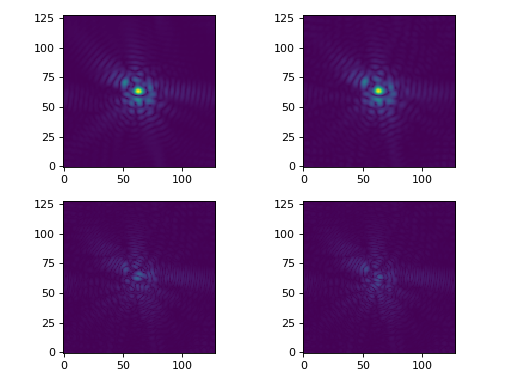

0.12949773965
0.084254041724
0.253730257782
0.224976048677


In [769]:
# Normalize PSFs
psfs_proper = psfs_proper / np.sum(psfs_proper, axis=(1,2))[:, None, None]
psfs_soapy = psfs_soapy / np.sum(psfs_soapy, axis=(1,2))[:, None, None]

from vip_hci.preproc import cube_shift
psfs_soapy_s = cube_shift(psfs_soapy, -0.25, -0.25, imlib='ndimage-fourier')



idx = 2
myNorm= MyNormalize('sqrt',
                    vmin=np.min(psfs_proper[idx]),
                    vmax=np.max(psfs_proper[idx]))


plt.figure()
plt.subplot(221)
plt.imshow(psfs_proper[idx, ::-1, ::-1], norm=myNorm)

plt.subplot(222)
plt.imshow(psfs_soapy[idx], norm=myNorm)
#plt.colorbar()

plt.subplot(223)
plt.imshow(np.abs(psfs_proper[idx, ::-1, ::-1] - psfs_soapy[idx]), norm=myNorm)
#plt.colorbar()
#plt.imshow(np.abs(psfs_proper[idx, ::-1, ::-1] - psfs_soapy[idx])/psfs_soapy[idx], vmin=0, vmax=1)

plt.subplot(224)
plt.imshow(np.abs(psfs_proper[idx, ::-1, ::-1] - psfs_soapy_s[idx]), norm=myNorm)
plt.tight_layout()

#fits.writeto('psf_soapy.fits', psfs_soapy[idx], overwrite=True)
#fits.writeto('psf_proper.fits', psfs_proper[idx, ::-1, ::-1], overwrite=True)

ii = np.argmax(np.abs(psfs_proper[idx, ::-1, ::-1] - psfs_soapy[idx]))
print(np.max(np.abs(psfs_proper[idx, ::-1, ::-1] - psfs_soapy[idx])) /psfs_soapy[idx].flatten()[ii])

ii = np.argmax(np.abs(psfs_proper[idx, ::-1, ::-1] - psfs_soapy[idx]))
print(np.max(np.abs(psfs_proper[idx, ::-1, ::-1] - psfs_soapy_s[idx])) / psfs_soapy_s[idx].flatten()[ii])

# print(np.argmax(np.abs(psfs_proper[idx, ::-1, ::-1] - psfs_soapy[idx])))
# print(np.argmax(psfs_soapy[idx]))

# Relative error on total flux
print(np.sum(np.abs(psfs_proper[idx, ::-1, ::-1] - psfs_soapy[idx])) / np.sum(psfs_soapy[idx]))
print(np.sum(np.abs(psfs_proper[idx, ::-1, ::-1] - psfs_soapy_s[idx])) / np.sum(psfs_soapy_s[idx]))

#### recentering with VIP experimentation

running cube_recenter_2dfit on non-aberrated PSF, we see that
soapy should be shifted in x, y by -0.25

In [401]:
# Recentering with VIP
import sys
sys.path.append('/home/gilles/github/VIP/')
from vip_hci.preproc import frame_shift, frame_center_radon, cube_recenter_2dfit

ss = -0.25
psf0 = psfs_soapy[idx]
psf_soapy_rc = frame_shift(psf0, ss, ss, imlib='ndimage-fourier', interpolation='bilinear')


ss= 0 #.25
psf1 = psfs_proper[idx, ::-1, ::-1]
psf_proper_rc = frame_shift(psf1, ss, ss, imlib='ndimage-interp', interpolation='bilinear')

# psf0 = psfs_soapy[idx:idx+2,:,:]
# psf_soapy_rc = psf1
# #psf_soapy_rc, ys, xs = cube_recenter_2dfit(psf0, full_output=True)
# #print(xs, ys)

# psf1 = psfs_proper[idx:idx+2,::-1,::-1]
# psf_proper_rc, yp, xp = cube_recenter_2dfit(psf1,full_output=True)
# print(xp, yp)



<IPython.core.display.Javascript object>


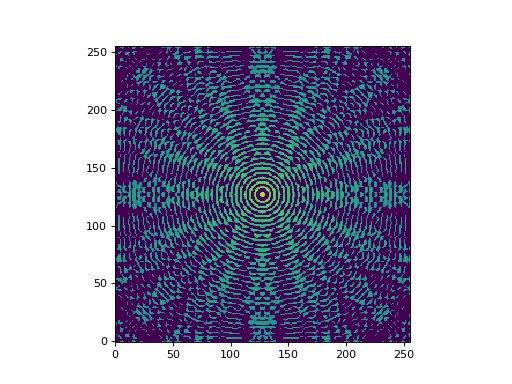

<IPython.core.display.Javascript object>


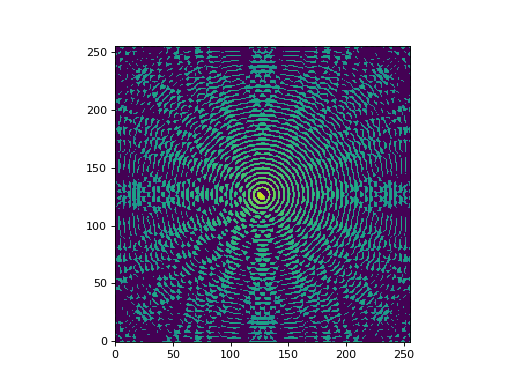

0.00230478979208
0.00651517191052


In [402]:
ii=0
plt.figure()
#plt.imshow(psf_proper_rc[ii] - psf_soapy_rc[ii], norm=myNorm)
plt.imshow(psf_proper_rc - psf_soapy_rc, norm=myNorm)

plt.figure()
plt.imshow(psfs_proper[idx, ::-1, ::-1] - psfs_soapy[idx], norm=myNorm)

#print(np.max(psf_proper_rc[ii] - psf_soapy_rc[ii]))
print(np.max(psf_proper_rc - psf_soapy_rc))
print(np.max(psfs_proper[idx, ::-1, ::-1] - psfs_soapy[idx]))